# What Makes A Good Product?

E-commerce has grown a lot and people have gone more and more reliant on it over brick and mortar stores. Mainly because of how easy it is to order, and it wastes very little time. However, the main drawback of ordering anything online is the customer's perception of the product and the actual thing, which is why people are more reliant on reviews to see if it's worth buying. Reviews are also important in the business to determine if the product is good enough and what can be improved. This can also indirectly affect sales as products with more negative reviews would less likely get sold, same logic can also be said for positive reviews.

This analysis will revolve around the performance of the product, and how other factors such as age groups and product category affect the overall quality.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#data visualization
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches #create custom legends
plt.style.use("ggplot")

#text pre-processing
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer, word_tokenize #tokenization of words
from nltk.stem import WordNetLemmatizer 
stop = stopwords.words("english")

#text visualization
from wordcloud import WordCloud, STOPWORDS #wordcloud generator for reviews
from nltk import pos_tag #Part of Speech tagging which will be used alongside the wordcloud

np.random.seed(92384) #for repeatability
        
df = pd.read_csv("Womens Clothing E-Commerce Reviews.csv", index_col = 0 )

In [2]:
df.columns

Index(['Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')

In [3]:
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


## Does the data make any sense?

Before any analysis will be done, let's check the quality of the data. In this section the following procedures will be done:

1. Check for any NaN values in the dataset.
2. Decesing to fill in or take out the missing values.
3. Text Pre-Processing for visual anlaysis.
4. Feature engineering by adding net promoter score. This will be used to understand the distribution of the ratings.

In [4]:
df.isnull().sum()/df.shape[0]*100

Clothing ID                 0.000000
Age                         0.000000
Title                      16.222430
Review Text                 3.597888
Rating                      0.000000
Recommended IND             0.000000
Positive Feedback Count     0.000000
Division Name               0.059610
Department Name             0.059610
Class Name                  0.059610
dtype: float64

The plan here is to concatenate the Title and the Review Text columns and use this single parameter as part of the review analysis. Since there are NaN values on both of them, then they should be filled in so concatenation can happen.

In [5]:
#fill
df["Title"] = df["Title"].fillna("")
df["Review Text"] = df["Review Text"].fillna("")

#concatenate the title and review text columns
df["Product Review"] = df["Title"] + " " + df["Review Text"]

In [6]:
df.isnull().sum()/df.shape[0]*100

Clothing ID                0.00000
Age                        0.00000
Title                      0.00000
Review Text                0.00000
Rating                     0.00000
Recommended IND            0.00000
Positive Feedback Count    0.00000
Division Name              0.05961
Department Name            0.05961
Class Name                 0.05961
Product Review             0.00000
dtype: float64

In [7]:
df[df.isnull().any(axis = 1)].head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Product Review
9444,72,25,My favorite socks!!!,"I never write reviews, but these socks are so ...",5,1,0,NaN,NaN,NaN,"My favorite socks!!! I never write reviews, bu..."
13767,492,23,So soft!,I just love this hoodie! it is so soft and com...,5,1,1,NaN,NaN,NaN,So soft! I just love this hoodie! it is so sof...
13768,492,49,Wardrobe staple,Love this hoodie. so soft and goes with everyt...,5,1,0,NaN,NaN,NaN,Wardrobe staple Love this hoodie. so soft and ...
13787,492,48,,,5,1,0,NaN,NaN,NaN,
16216,152,36,Warm and cozy,"Just what i was looking for. soft, cozy and warm.",5,1,0,NaN,NaN,NaN,Warm and cozy Just what i was looking for. sof...


Although there are still missing data, I decided to leave it out because deleting it would result to the review text being deleted as well and it is essential to store as much text data as possible. When doing analysis handling the Division, Department, and Class Name, these will be ignored.

In [8]:
#text preprocessing
df["Product Review"] = df["Product Review"].str.lower() #lowercase text - normalization
df["Product Review"] = df["Product Review"].str.replace(r"[.!?\\,-]", "") #take out all punctuation marks - because they mess up your shit, walay labot ang comma sa taas

#tokenize using whitespace andlemmatize for normalization
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    w_tokenizer = WhitespaceTokenizer() #oringially used a word tokenizer but there were too many word contractions that would affect POS tagging
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)] 

df["Product Review"] = df["Product Review"].apply(lemmatize_text)
df["Product Review"] = df["Product Review"].apply(lambda x: [word for word in x if word not in stop])

The plan for data visualization of the text data is through the use of wordclouds. Pre-processing text is important mainly for normalization of data, so all the words of the same meaning will be grouped together, taking out the noise (punctuation marks), and use it as input for visualization.

Here are the following steps:
1. Lowercase the corpus - Main purpose is for normalization of data.
2. Taking out punctuation marks - They don't add any value when doing analysis.
3. Tokenization - In this case, white space tokenization has been used because there are a lot of conjunction words
4. Lemmatization - It turns all the text into their root word. Lemmatization has been used here instead of stemming because there's very small data that is being played with.
5. Stop word removal - They don't add any value in the sentence.

In [9]:
#this will be used to determine score of the product
condlist = [df["Rating"] >= 4, df["Rating"] == 3, df["Rating"] <= 2]
choicelist = ["Positive", "Neutral", "Negative"]

df["Net Promoter Score"] = np.select(condlist, choicelist)

Net promoter score is a measure to understand customer satisfaction of the product. The ratings have been defined from 1 through 5, with being the lowest. It would be easier to visualize the data when they are being grouped together.

In this case, here are the groups:
1. Positive - Scores that are greater than or equal to 4
2. Neutral - Scores that are equal to 3.
3. Negative - Any rating that is less than or equal to 2.


Link to [Net Promoter Score](https://www.hotjar.com/net-promoter-score/)

In [10]:
condlist = [df["Age"] <= 25, ((df["Age"] > 25) & (df["Age"] <= 40)), df["Age"] >= 41]
choicelist = ["Gen Z", "Millenials", "Baby Boomers"]

df["Age Group"] = np.select(condlist, choicelist)

The use of the age group column is to analyze which segment gets the most reviews as well as understand the distribution of reviews, how many are negative or positive, which can possibly show that some outfits are better suited for a certain age group.

In [11]:
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Product Review,Net Promoter Score,Age Group
0,767,33,,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,"[absolutely, wonderful, silky, sexy, comfortable]",Positive,Millenials
1,1080,34,,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,"[love, dress, sooo, pretty, happened, find, st...",Positive,Millenials
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,"[major, design, flaw, high, hope, dress, reall...",Neutral,Baby Boomers
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,"[favorite, buy, love, love, love, jumpsuit, fu...",Positive,Baby Boomers
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,"[flattering, shirt, shirt, flattering, due, ad...",Positive,Baby Boomers


Now that we have cleaned up, processed, and added in new features into the dataset, data exploration is next.

# Do you like your clothes?

It is time to see how these items are perceived by the consumers. The following questions will be asked:

1. Which clothing division has the most reviews?
2. Do people generally prefer 1 group category over the other?
3. Does age affect review ratings?
4. Which clothing department has the best and worst reviews?
5. Which clothing ID has the best and worst reviews?

In [12]:
#create a table that would describe the telll the median number of reviews per item and how many items are under those
summ_dict = {"Clothing ID":"count", "Rating":"mean", "Recommended IND":"sum", "Positive Feedback Count":"sum"}
clothing_summary = df.groupby("Clothing ID").agg(summ_dict).rename(columns={"Clothing ID":"Review counts"}).reset_index()

median_clothing_rev = clothing_summary["Review counts"].median()
clothing_items_less_med = clothing_summary[clothing_summary["Review counts"] < clothing_summary["Review counts"].median()].shape[0]

print("Median number of reviews for each clothing is {:.0f} with over {} items less than or equal to {:.0f} reviews.".format(median_clothing_rev, clothing_items_less_med, median_clothing_rev))

Median number of reviews for each clothing is 2 with over 491 items less than or equal to 2 reviews.


## Which Clothing Division Has The Most Reviews?

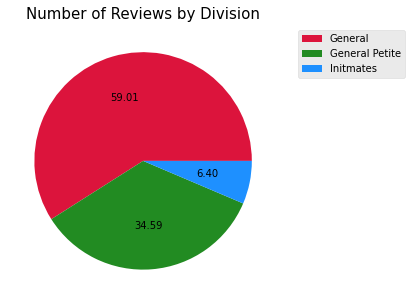

In [13]:
color_division = ["crimson", "forestgreen", "dodgerblue"]

df["Division Name"].value_counts().plot(kind = "pie", autopct = "%.2f", figsize = (5,5), colors = color_division, labeldistance = None)
plt.title("Number of Reviews by Division", fontsize = 15)  
plt.legend(bbox_to_anchor = (1.05, 1))
plt.ylabel("");

Most popular items are coming from the general division, followed by petite, and only a small section of the demographic created a review under intimates.

## How Does Each Clothing Group Perform Against One Another?

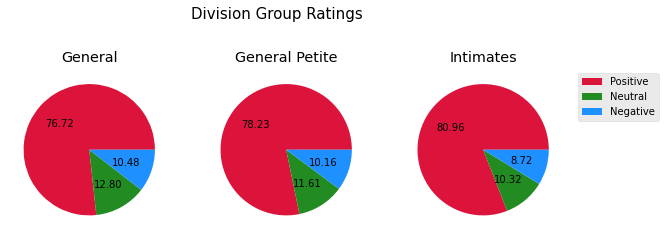

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (10, 5))

df[df["Division Name"] == "General"]["Net Promoter Score"].value_counts().plot(kind = "pie", ax = ax1, autopct = "%.2f", colors = color_division, labeldistance = None)
df[df["Division Name"] == "General Petite"]["Net Promoter Score"].value_counts().plot(kind = "pie", ax = ax2, autopct = "%.2f", colors = color_division, labeldistance = None)
df[df["Division Name"] == "Initmates"]["Net Promoter Score"].value_counts().plot(kind = "pie", ax = ax3, autopct = "%.2f", colors = color_division, labeldistance = None)

ax1.set_title("General")
ax2.set_title("General Petite")
ax3.set_title("Intimates")

ax1.set_ylabel("")
ax2.set_ylabel("")
ax3.set_ylabel("")

plt.suptitle("Division Group Ratings", fontsize = 15, y = 0.9)
plt.legend(bbox_to_anchor = (1.05, 1));

General and General Petite have fairly the same distribution. While Intimates have a slight lead with its positive reviews.

## Does Age Group Affect Ratings?

In [15]:
age_group_score = df.groupby(["Age Group", "Net Promoter Score"]).agg({"Net Promoter Score":"count"}).rename(columns = {"Net Promoter Score":"Review Count"}).unstack().reset_index()
age_summ = df.groupby("Age Group")["Net Promoter Score"].count().reset_index() #Net Promoter Score is the total number of reviews

age_group_score = age_group_score.merge(age_summ, on = "Age Group")

age_group_score["Negative %"] = age_group_score[("Review Count", "Negative")]/age_group_score["Net Promoter Score"]*100
age_group_score["Neutral %"] = age_group_score[("Review Count", "Neutral")]/age_group_score["Net Promoter Score"]*100
age_group_score["Positive %"] = age_group_score[("Review Count", "Positive")]/age_group_score["Net Promoter Score"]*100

C:\Users\Pierce\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


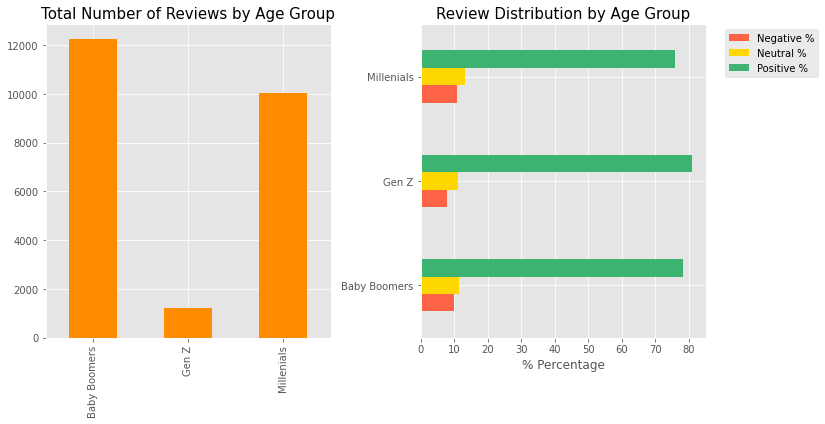

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (10, 6))

age_group_score[["Age Group", "Net Promoter Score"]].plot(kind = "bar", ax = ax1, legend = False, color = "darkorange")
ax1.set_title("Total Number of Reviews by Age Group", fontsize = 15)
ax1.set_xticks(np.arange(3))
ax1.set_xticklabels(["Baby Boomers", "Gen Z", "Millenials"])


age_group_score[["Age Group", "Negative %", "Neutral %", "Positive %"]].plot(kind = "barh", ax = ax2, legend = False, color = ["tomato", "gold", "mediumseagreen"])
ax2.set_title("Review Distribution by Age Group", fontsize = 15)
ax2.set_yticks(np.arange(3))
ax2.set_yticklabels(["Baby Boomers", "Gen Z", "Millenials"])
ax2.set_xlabel("% Percentage")

plt.tight_layout()
plt.legend(bbox_to_anchor = (1.05, 1));

Most outspoken group is coming from baby boomers, and the lowest number of reviews, with less than 2000 reviews, are the Gen Z. However, the distribution of reviews pper age group is roughly the same all thourghout, this means that age doesn't affect the reviews much.

In [17]:
df[["Age", "Rating"]].corr()

,Age,Rating
Age,1.000000,0.026831
Rating,0.026831,1.000000


Pearson correlation proves that age doesn't affect the rating of the clothing.

## Which Clothing Department Has The Best And Worst Reviews?

In [18]:
#a table used to identify the number of negative and positive reviews based off of their groups
review_scores = df.groupby(["Division Name", "Department Name", "Net Promoter Score"])["Net Promoter Score"].count().unstack(fill_value = 0).reset_index()

#used a percentage based column to normalize the data,since there will be some clothing groups that have more reviews over the others
review_scores["Total Reviews"] = review_scores["Negative"] + review_scores["Neutral"] + review_scores["Positive"]
review_scores["Negative Reviews %"] = review_scores["Negative"]/review_scores["Total Reviews"]*100
review_scores["Neutral Reviews %"] = review_scores["Neutral"]/review_scores["Total Reviews"]*100
review_scores["Positive Reviews %"] = review_scores["Positive"]/review_scores["Total Reviews"]*100

In [19]:
review_scores.head()

Net Promoter Score,Division Name,Department Name,Negative,Neutral,Positive,Total Reviews,Negative Reviews %,Neutral Reviews %,Positive Reviews %
0,General,Bottoms,222,296,2024,2542,8.733281,11.644375,79.622345
1,General,Dresses,384,525,2821,3730,10.294906,14.075067,75.630027
2,General,Jackets,67,60,518,645,10.387597,9.302326,80.310078
3,General,Tops,759,879,5199,6837,11.101360,12.856516,76.042124
4,General,Trend,19,13,64,96,19.791667,13.541667,66.666667


In [20]:
#a function that will be used to create a color scheme depenedent on the Division Name
def enum_list(dataframe):

    list_name = dataframe["Division Name"].tolist()
    color_list = []

    for index in list_name:
        if index == "General": color_list.append("crimson")
        elif index == "General Petite": color_list.append("forestgreen")
        else: color_list.append("dodgerblue")
    return color_list

#create a legend that would be dependent on the Division Name
color_dict = {"General":"crimson", "General Petite":"forestgreen", "Intimates":"dodgerblue"}
handles = []

for key, value in color_dict.items():
    patch = mpatches.Patch(color=value, label=key) # manually define a new patch 
    handles.append(patch) # handles is a list, so append manual patch

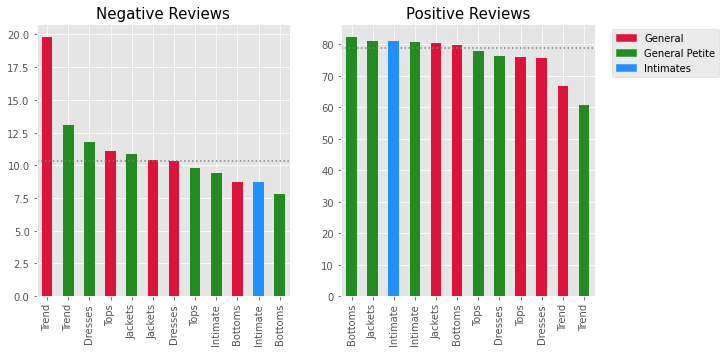

In [21]:
worst_reviews = review_scores.sort_values("Negative Reviews %", ascending = False)
best_reviews = review_scores.sort_values("Positive Reviews %", ascending = False)

fig, (ax1, ax2) = plt.subplots(ncols =2, figsize = (10,5))

worst_reviews.plot(kind = "bar", x = "Department Name",  y = "Negative Reviews %", ax=ax1, legend = False, color = enum_list(worst_reviews))
ax1.axhline(y = review_scores["Negative Reviews %"].median(), color = "gray", linestyle = ":")
ax1.set_title("Negative Reviews", fontsize = 15)
ax1.set_xlabel("")

best_reviews.plot(kind = "bar", x = "Department Name", y = "Positive Reviews %", ax=ax2, legend = False, color = enum_list(best_reviews))
ax2.axhline(y = review_scores["Positive Reviews %"].median(), color = "gray", linestyle = ":")
ax2.set_title("Positive Reviews", fontsize = 15)
ax2.set_xlabel("")

plt.legend(handles = handles, bbox_to_anchor = (1.05, 1))

Insights:

1. Generally, bottoms and intimates have the least % amount of negative reviews and correlates well with a high positive % review score.
2. Women's tops such as under the trend, dresses, tops and jackets are over the median negative %. We'll check this further through the use of wordclouds and POS tagging and find out why and what are certain charateristics of these items that have high negative reviews.

## Which Clothing ID Has The Best And Worst Reviews?

In [22]:
#please add more info regarding this table
clothing_df = pd.crosstab([df["Division Name"], df["Department Name"], df["Class Name"], df["Clothing ID"]], df["Net Promoter Score"]).reset_index()

clothing_df["Total Reviews"] = clothing_df["Negative"] + clothing_df["Neutral"] + clothing_df["Positive"] 
clothing_df["Negative Reviews %"] = clothing_df["Negative"]/clothing_df["Total Reviews"] *100
clothing_df["Neutral Reviews %"] = clothing_df["Neutral"]/clothing_df["Total Reviews"] *100
clothing_df["Positive Reviews %"] = clothing_df["Positive"]/clothing_df["Total Reviews"] *100

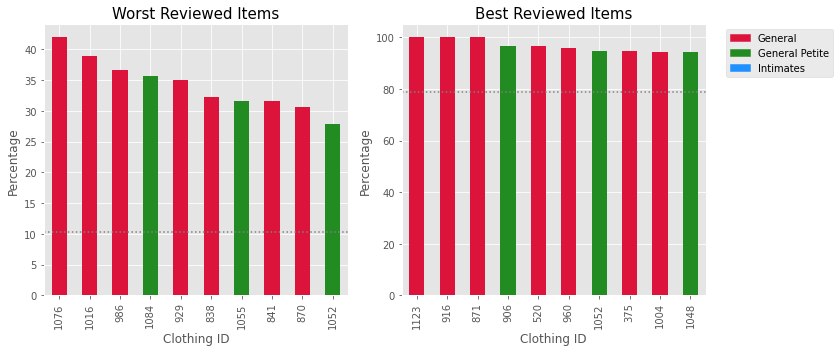

In [23]:
worst_items = clothing_df[(clothing_df["Total Reviews"] >= 15)].sort_values("Negative Reviews %", ascending = False)
best_items = clothing_df[(clothing_df["Total Reviews"] >= 15)].sort_values("Positive Reviews %", ascending = False)

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (10, 5))

worst_items.head(10).plot(kind = "bar", x = "Clothing ID", y = "Negative Reviews %", color = enum_list(worst_items), ax = ax1, legend = False)
ax1.axhline(y = review_scores["Negative Reviews %"].median(), color = "gray", linestyle = ":") #baseline
ax1.set_title("Worst Reviewed Items", fontsize = 15)
ax1.set_ylabel("Percentage")

best_items.head(10).plot(kind = "bar", x = "Clothing ID", y = "Positive Reviews %", color = enum_list(worst_items), ax = ax2)
ax2.axhline(y = review_scores["Positive Reviews %"].median(), color = "gray", linestyle = ":") #baseline
ax2.set_title("Best Reviewed Items", fontsize = 15)
ax2.set_ylabel("Percentage")

plt.tight_layout()
plt.legend(handles = handles, bbox_to_anchor = (1.05, 1))

In [24]:
clothing_df[clothing_df["Total Reviews"] >= 15].sort_values("Negative Reviews %", ascending = False).head(10)

Net Promoter Score,Division Name,Department Name,Class Name,Clothing ID,Negative,Neutral,Positive,Total Reviews,Negative Reviews %,Neutral Reviews %,Positive Reviews %
178,General,Dresses,Dresses,1076,13,0,18,31,41.935484,0.000000,58.064516
164,General,Bottoms,Skirts,1016,7,2,9,18,38.888889,11.111111,50.000000
247,General,Jackets,Jackets,986,11,2,17,30,36.666667,6.666667,56.666667
538,General Petite,Dresses,Dresses,1084,10,3,15,28,35.714286,10.714286,53.571429
393,General,Tops,Sweaters,929,7,4,9,20,35.000000,20.000000,45.000000
294,General,Tops,Blouses,838,10,2,19,31,32.258065,6.451613,61.290323
477,General Petite,Bottoms,Pants,1055,6,2,11,19,31.578947,10.526316,57.894737
297,General,Tops,Blouses,841,6,3,10,19,31.578947,15.789474,52.631579
359,General,Tops,Knits,870,11,7,18,36,30.555556,19.444444,50.000000
475,General Petite,Bottoms,Pants,1052,5,3,10,18,27.777778,16.666667,55.555556


Insights:

1. Over 70% of the mos negative reviews are coming from the General Division, followed by the General Petite.
2. There are over 3 items that have a 100% positive rating, which came from the General Division. A closer look at the items, they are under the Outerwear, Fine Gauge, and Knits Class Name.

Note: Clothing ID's have been filtered out with atleast 15 reviews to have enough data for analysis.

All these items will be further explored by taking a look at their reviews.

# What makes a good/bad product?

From the previous section, we have learned the following:

1. Breaking down the scores by their Division Name, they practically have the same score distribution except for Intimates having a very slight advantage with its positive reviews.
2. The distribution of NPS scores by Age groups are practically the same. Which means that the item's review rating and a persons age show very little correlation.
3. The negative reviews are usually coming from women's tops such as: Trend, Dresses, Tops, and Jackets.
4. A lot of these items are positively reviewed. However, there are some particular products that have gained a lot of negative reviews that contributed to pulling down the overall ratings of the category group.
5. We have also identified the worst and best performing items.
6. Most reviewed items are coming from the Baby Boomers, and there's hardly any interaction coming from the Gen Z.

Let's dig a little bit deeper now by understanding the review text. Visual analysis of the text would be done by word clouds. However, since we want to know more of **WHY** the products are doing well and **WHAT** is in the product that satisfies people then we have to find a way to separate the words out. POS tagging will be used where all noun words will be placed into a single list to understand the how, while the adjectives will be added under another list to understand the why of the product.

In [25]:
#a function that would output a joined list usable for wordclouds
def create_wordcloud(filt_df, pos, axis):
    
    filt_df = filt_df.apply(pos_tag)
    flatlist = []
    
    for index in filt_df:
        for df_index in index:
            if pos == "adjective":
                if (df_index[1] == "JJ" or df_index[1] == "JJR" or df_index[1] == "JJS"):
                    flatlist.append(df_index[0])
            elif pos == "noun":
                if (df_index[1] == "NN" or df_index[1] == "NNS" or df_index[1] == "NNP" or df_index[1] == "NNPS" or df_index[1] == "PRP" or df_index[1] == "PRP$"):
                    flatlist.append(df_index[0])
    
    wordcloud = WordCloud(
        max_words = 30, width = 3000, height = 2000, background_color = "white").generate(" ".join(flatlist))
    axis.set_xticks([])
    axis.set_yticks([])
    axis.imshow(wordcloud, interpolation = "bilinear")

Description of the function:

1. filt_df is the filtered dataframe that we want to slice and pos is the tagged that will be used for the word cloud and in this case only the "noun" and the "adjective" will be used.
2. A empty list will be instantiated, and then the words will be appended depending on the pos tag.
3. The returned list, will then be used as an input for the word cloud.

## Worst items

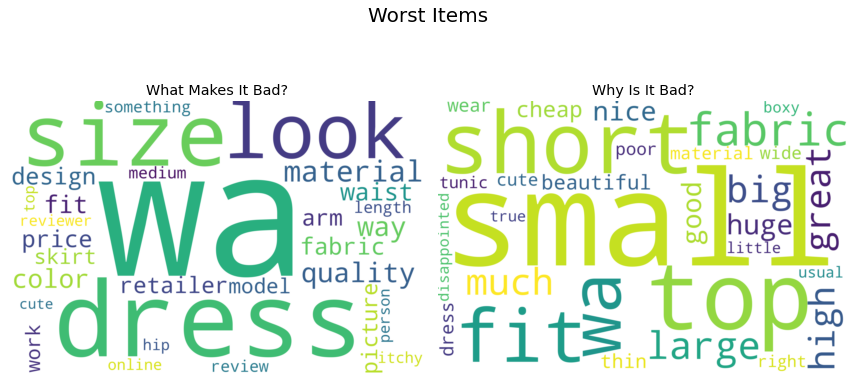

In [26]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12,10), facecolor = "w", edgecolor = "k")


create_wordcloud(df[(df["Clothing ID"].isin(worst_items.head(10)["Clothing ID"].tolist())) & (df["Net Promoter Score"] == "Negative")]["Product Review"], "noun", ax1)
create_wordcloud(df[(df["Clothing ID"].isin(worst_items.head(10)["Clothing ID"].tolist())) & (df["Net Promoter Score"] == "Negative")]["Product Review"], "adjective", ax2)

ax1.set_title("What Makes It Bad?")
ax2.set_title("Why Is It Bad?")

plt.suptitle("Worst Items", fontsize = 20, y = 0.8)
plt.tight_layout()
plt.show()


In [27]:
df[(df["Clothing ID"].isin(worst_items.head(10)["Clothing ID"].tolist())) & (df["Net Promoter Score"] == "Negative")]["Review Text"].sample(5)

20540    Quality jumpsuit but poor design. the green ma...
1984     What an adorable and frustrating skirt! i'm no...
20506    So unflattering! really disappointed. made me ...
6706     This fell apart after wearing it once. for the...
8972     I love relaxed-fit wide leg pants with some po...
Name: Review Text, dtype: object

The worst reviewed items have an issue with the overall quality and the fit of the product. Materials are known to have a cheap feel and is very thin. It probably has bad proportions, which is why the fit of the clothing is really bad.

## Best Items

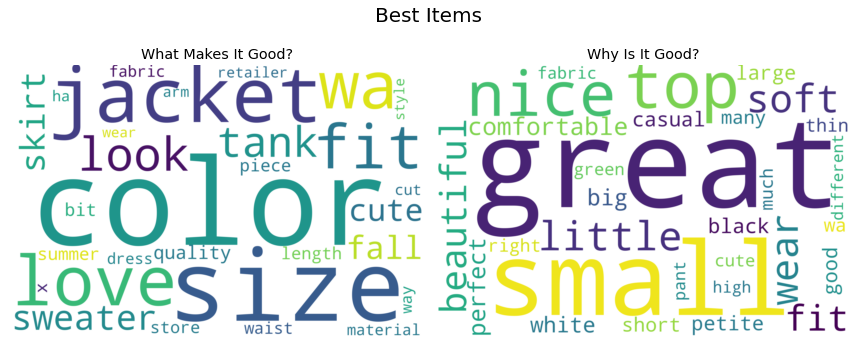

In [28]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12,10), facecolor = "w", edgecolor = "k")

create_wordcloud(df[(df["Clothing ID"].isin(best_items.head(10)["Clothing ID"].tolist())) & (df["Net Promoter Score"] == "Positive")]["Product Review"], "noun", ax1)
create_wordcloud(df[(df["Clothing ID"].isin(best_items.head(10)["Clothing ID"].tolist())) & (df["Net Promoter Score"] == "Positive")]["Product Review"], "adjective", ax2)

ax1.set_title("What Makes It Good?")
ax2.set_title("Why Is It Good?")

plt.suptitle("Best Items", fontsize = 20, y = 0.75)
plt.tight_layout()
plt.show()


In [29]:
df[(df["Clothing ID"].isin(best_items.head(10)["Clothing ID"].tolist())) & (df["Net Promoter Score"] == "Positive")]["Review Text"].sample(5)

20174    I ordered the red motif in size m based on rev...
11715    Beautiful color and soft texture. this piece i...
10170    I just purchased this amazing jacket in the mo...
5964     I got this skirt earlier this week and wore it...
20105    I love this style of tank top with the wider s...
Name: Review Text, dtype: object

Apparently, the very same things that people hate on the worst reviewed products, are the very same things that have been said on the most positive reviewed items. This could possibly mean that the raw materials from those items that have been negatively reviewed, have overall bad quality.

Note: I originally added in here the word cloud of the worst performing departments, but I decided to take it out mainly because its the different Clothing ID's are the reason for the bad ratings.

# What's Next?

The main focus of this analysis is to understand how different customers affect clothing ratings. We have learned that age doesn't necessarily affect the review ratings, breaking down the Net Promoter Score by its division group doesn't show any difference, the most outspoken group came from the baby boomers, and we've identified the best and worst performing Clothing Id's. Going further into that, we saw that the very same reasons for why people hate the product on the worst reviewed section are the same things why people love the product on the best items section. This leads me to believe that the reason for the bad products came from the source of the raw materials as well as the assmebly plant of the clothes. Those should be determined and be changed or altogether take out the specific clothing ID's as negative reviews can directly affect the sales of the product.


